<a href="https://colab.research.google.com/github/moulaali/ml/blob/master/pytorch_demo_psenti.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Pytorch demo

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob, Word
import nltk
import seaborn as sns
nltk.download('punkt')
sns.set(rc={'figure.figsize':(20,20)})
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
from google.colab import files
uploaded = files.upload()

Saving yelp.csv to yelp.csv


In [ ]:
import pandas as pd
yelp = pd.read_csv('/content/yelp.csv')
yelp

In [ ]:
# Create a vocab index
corpus = yelp.text[:2].values
vocabulary = dict()
ix = 0

for sentence in corpus:
  for word in TextBlob(sentence).words:
    vocabulary[ix] = word
    ix += 1

print("Vocabulary loaded")
vocabulary

In [ ]:
ohe_vectorizer = CountVectorizer()
ohe_representation = ohe_vectorizer.fit_transform(corpus).toarray()
ohe_representation

<Axes: >

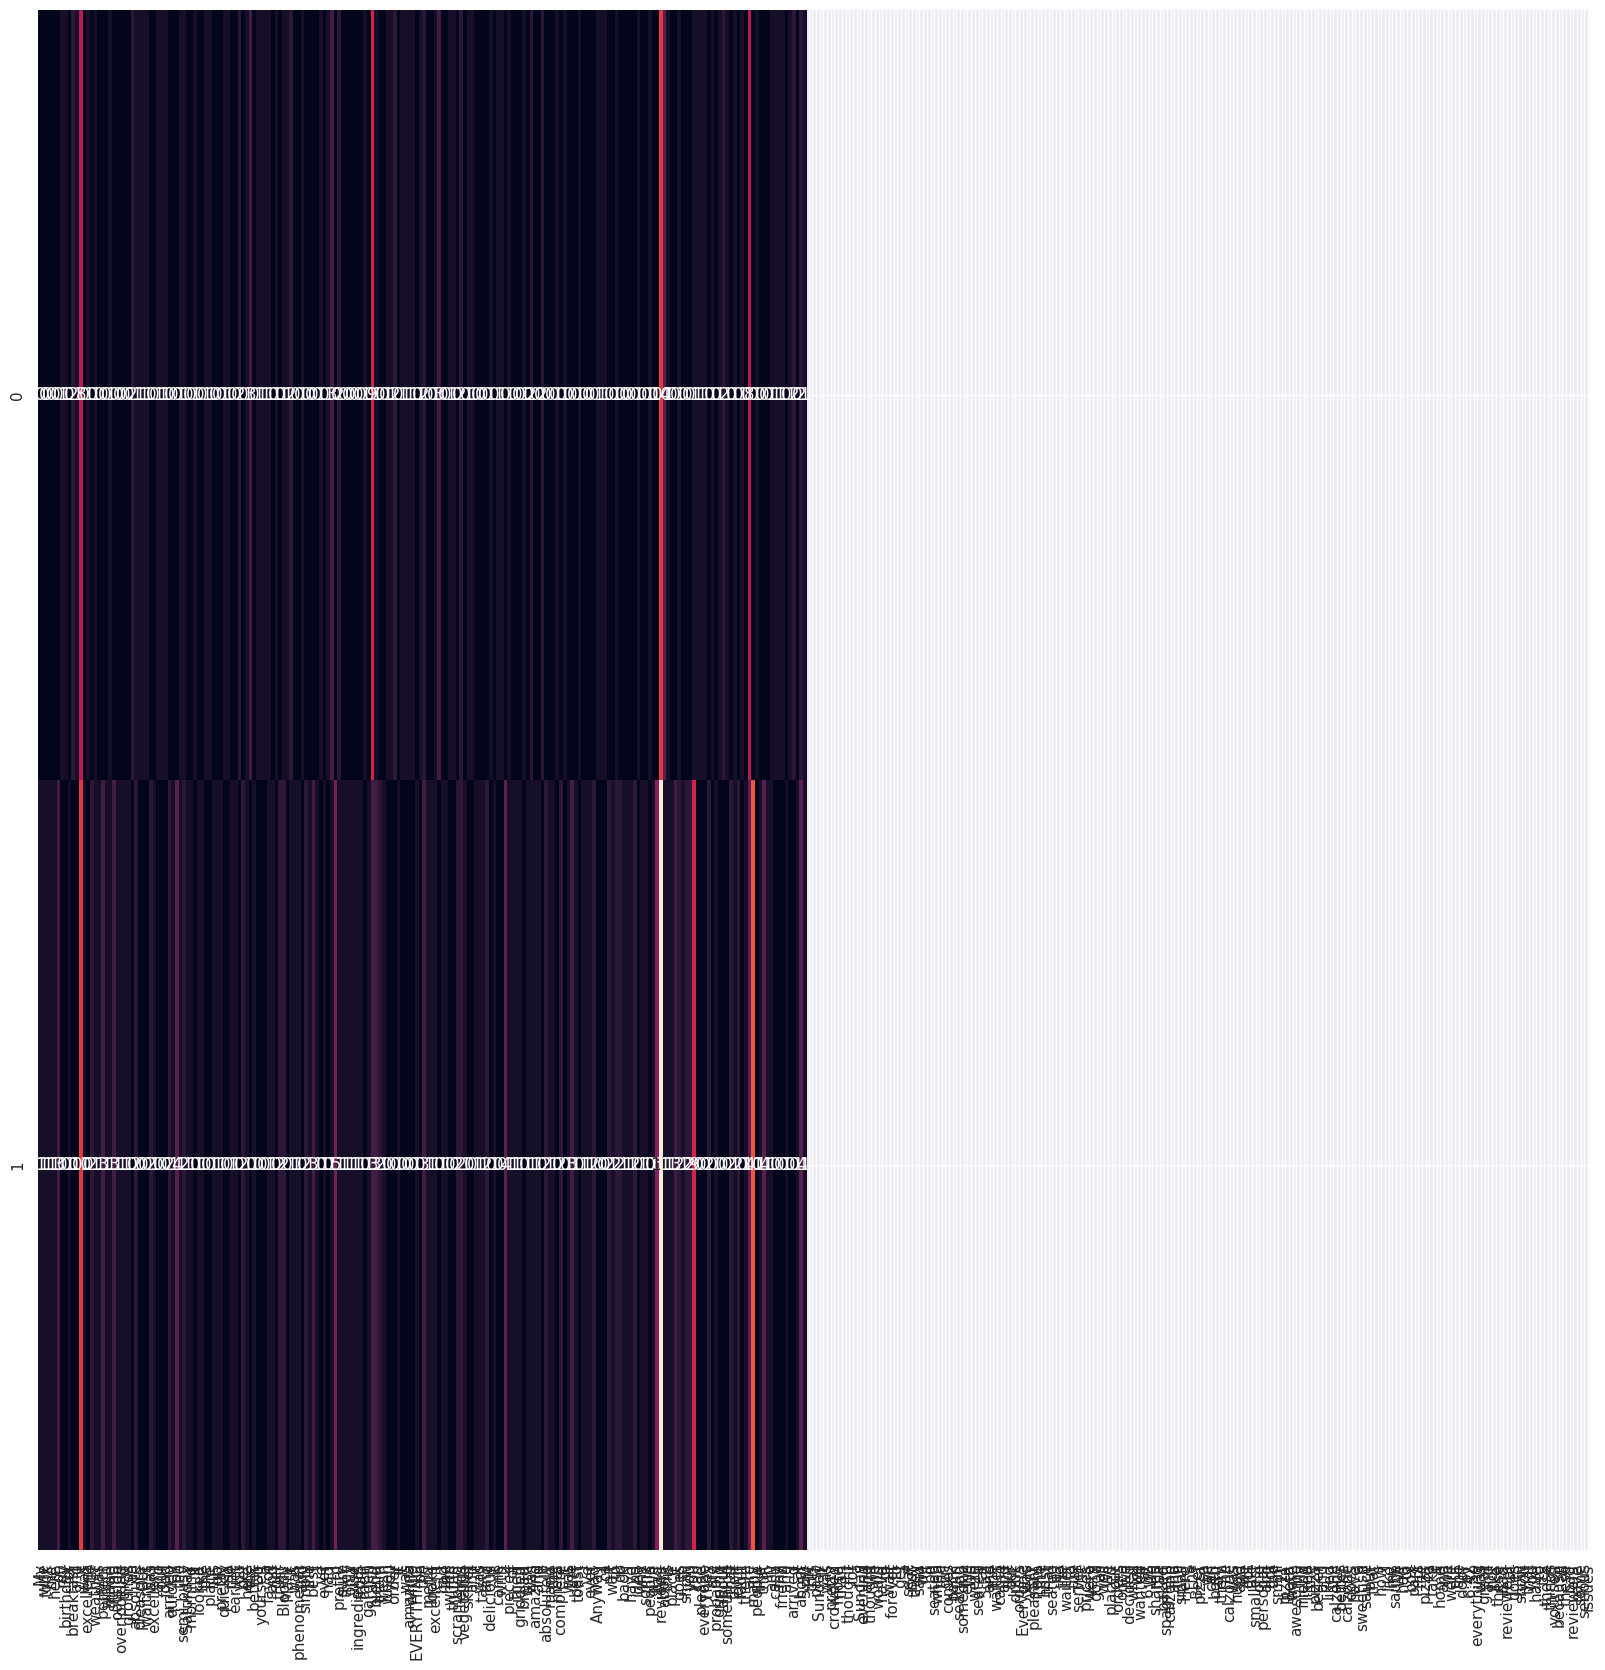

In [20]:
sns.heatmap(ohe_representation, annot=True, xticklabels=vocabulary.values(), cbar=False)

In [21]:
import torch
from torch import nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [22]:
# Create a new DataFrame that only contains the 5-star and 1-star reviews.
yelp_best_worst = yelp[(yelp.stars==5) | (yelp.stars==1)]

# Define X and y.
X = yelp_best_worst.text
y = yelp_best_worst.stars.map({1:0, 5:1})

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [25]:
vect = CountVectorizer()
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)

In [26]:
X_train_tensor = torch.Tensor(X_train_dtm.toarray()).to(device)
X_test_tensor = torch.Tensor(X_test_dtm.toarray()).to(device)
y_train = torch.Tensor(y_train.values).type(torch.LongTensor).to(device)
y_test = torch.Tensor(y_test.values).type(torch.LongTensor).to(device)

In [27]:
model = nn.Sequential(
  nn.Linear(X_train_tensor.shape[1], 2),
  nn.LogSoftmax(dim = 1)
).to(device)

In [28]:
def forward(X):
  return model(X).to(device)

def loss(y_pred, y):
  return nn.functional.nll_loss(y_pred, y)

print("forward and loss functions defined")

forward and loss functions defined


In [29]:
def metric(y_pred, y):  # -> accuracy
  return (1 / len(y)) * ((y_pred.argmax(dim = 1) == y).sum())

In [30]:
optimizer = torch.optim.AdamW(model.parameters())

In [32]:
epochs = 250

for i in range(epochs):
  y_pred = forward(X_train_tensor)          # Forward pass
  xe = loss(y_pred, y_train)                # Calculate loss
  accuracy = metric(y_pred, y_train)        # Calculate metric
  xe.backward()                             # Backward pass
  optimizer.step()                          # Step on optimizer
  optimizer.zero_grad()                     # Zero out gradients
  if i % 50 == 0:                          # Log ever 100 epochs
    print("Loss: ", xe, " Accuracy ", accuracy.data.item())


print("Model trained")


Loss:  tensor(0.6603, grad_fn=<NllLossBackward0>)  Accuracy  0.7711138725280762
Loss:  tensor(0.2110, grad_fn=<NllLossBackward0>)  Accuracy  0.9718482494354248
Loss:  tensor(0.1286, grad_fn=<NllLossBackward0>)  Accuracy  0.9920440912246704
Loss:  tensor(0.0921, grad_fn=<NllLossBackward0>)  Accuracy  0.9938800930976868
Loss:  tensor(0.0711, grad_fn=<NllLossBackward0>)  Accuracy  0.9951040744781494
Model trained


In [33]:
y_test_pred = forward(X_test_tensor)
print(f'Model accuracy is {metric(y_test_pred, y_test)}')

Model accuracy is 0.898533046245575
